<a href="https://colab.research.google.com/github/van-dang/MRI-Cloud/blob/master/RealNeurons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# About the code

In [0]:
# This program solves the Bloch-Torrey equation applied to computational diffusion MRI using 
# the finite element method coupled with the theta-method for the spatial discretization.

# The scope of usage: 
# (1) Single domains, Multilayered structures, manifolds
# (2) Membrane permeability for internal interfaces
#     Artificial permeability at the external interfaces
# (3) pure homogeneous Neumann BCs, (4) pseudo-periodic BCs

# Copyright (C) 2019 Van-Dang Nguyen (vdnguyen@kth.se)

# This file is part of DOLFIN.

# DOLFIN is free software: you can redistribute it and/or modify
# it under the terms of the GNU Lesser General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.

# DOLFIN is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the
# GNU Lesser General Public License for more details.

# You should have received a copy of the GNU Lesser General Public License
# along with DOLFIN. If not, see <http://www.gnu.org/licenses/>.

# First added:  2017-10-10
# Last changed: 2019-04-25

# This demo is maintained by Van-Dang Nguyen
# Please report possible problems to vdnguyen@kth.se

# Setting a working environment with FEniCS

In [2]:
from google.colab import files

import platform, sys
python_version=platform.python_version()
from distutils.version import LooseVersion, StrictVersion

if ( LooseVersion(python_version) < LooseVersion("3.0.0")):
    print("Python3 is needed!");
    print("How to fix: Runtime/Change_runtime_type/Python 3");
    sys.exit()
    
try:
    from dolfin import *; from mshr import *
except ImportError as e:
    !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
    !add-apt-repository -y ppa:fenics-packages/fenics
    !apt-get update -qq
    !apt install -y --no-install-recommends fenics
    from dolfin import *; from mshr import *

gmsh_dir=!which gmsh
if len(gmsh_dir)==0:
  !apt-get install gmsh
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display; import time; import dolfin.common.plotting as fenicsplot 
import time

import os, sys, shutil

import sympy as sp


clear_output()

dolfin_version = dolfin.__version__
print ('dolfin version:', dolfin_version)

# Disable warnings
import logging
logging.basicConfig(level=logging.DEBUG)
logger = logging.getLogger("rothemain.rothe_utils")
logging.getLogger('UFL').setLevel(logging.WARNING)
logging.getLogger('FFC').setLevel(logging.WARNING)

import warnings
warnings.filterwarnings("ignore")


dolfin version: 2019.1.0


#Load pre-defined functions

In [3]:
import sympy as sp  
exists = os.path.isfile('DmriFemBuitInFunc.py')
isupdate = False
if (exists==False or isupdate==True):
    if isupdate==True:
        !rm DmriFemBuitInFunc.py
    print("Load pre-defined functions from GitHub")
    !wget --quiet https://raw.githubusercontent.com/van-dang/MRI-Cloud/master/DmriFemBuitInFunc.py
from DmriFemBuitInFunc import *

Load pre-defined functions from GitHub


# Working on the mesh

In [4]:
geo_choice = 2

if geo_choice == 1:
      mesh_file = "fru_M_100383_1D.xml"
      mesh_file_exists = os.path.isfile('fru_M_100383_1D.xml')
      if (mesh_file_exists==False):
          !wget https://raw.githubusercontent.com/van-dang/MRI-Cloud/mesh/$mesh_file''.zip
          !unzip -q $mesh_file''.zip
      mymesh = Mesh(mesh_file);

if geo_choice == 2:
      spindle_list=['03a_spindle2aFI','03a_spindle6aFI','03b_spindle4aACC','03b_spindle5aACC',
                    '03b_spindle6aACC','03b_spindle7aACC','04b_spindle3aFI','05b_spindle5aFI',
                    '06b_spindle8aACC','07b_spindle9aACC','08a_spindle13aACC','09o_spindle7aFI',
                    '09o_spindle8aFI','10a_spindle18aACC','12a_spindle19aACC','12o_spindle9aFI',
                    '13o_spindle10aFI','15o_spindle12aFI','16o_spindle13aFI','19o_spindle14aFI',
                    '21o_spindle15aFI','23o_spindle16aFI','25o_spindle17aFI','26o_spindle18aFI',
                    '27o_spindle19aFI','28o_spindle20aFI','28o_spindle21aFI','29o_spindle22aFI',
                    '30o_spindle23aFI',
      ];

      pyramidal_list=['02a_pyramidal2aFI','02b_pyramidal1aACC','02b_pyramidal1aFI','03a_pyramidal9aFI',
                      '03b_pyramidal2aACC','03b_pyramidal3aACC','03b_pyramidal3aFI','03b_pyramidal4aFI',
                      '03b_pyramidal9aFI','04a_pyramidal4aACC','04a_pyramidal5aACC','04b_pyramidal5aFI',
                      '04b_pyramidal6aACC','04b_pyramidal6aFI','04b_pyramidal7aACC','05a_pyramidal10aACC',
                      '05a_pyramidal8aACC','05b_pyramidal7aFI','05b_pyramidal8aFI','05b_pyramidal9aACC',
                      '06a_pyramidal11aACC','06b_pyramidal10aFI','06b_pyramidal12aACC','07a_pyramidal13aACC',
                      '07b_pyramidal14aACC','08o_pyramidal11aFI','10a_pyramidal15aACC','11a_pyramidal16aACC',
                      '11o_pyramidal12aFI','17o_pyramidal13aFI','18o_pyramidal14aFI','20o_pyramidal15aFI',
                      '22o_pyramidal16aFI','24o_pyramidal17aFI','25o_pyramidal18aFI','31o_pyramidal19aFI',
      ];

      neuron_id = 13;
      neuron_type = 'pyramidals';

      if neuron_type == 'spindles':
          neuron_list = spindle_list;
      if neuron_type == 'pyramidals':
          neuron_list = pyramidal_list;

      neuron_name = neuron_list[neuron_id];
      print(neuron_name)

      neuron_dir='https://raw.githubusercontent.com/van-dang/RealNeuronMeshes/master/'+neuron_type+'/'+neuron_name+'.msh.zip'

      mesh_file_exists = os.path.isfile(neuron_name+'.xml')

      if (mesh_file_exists == False):
          !wget -q $neuron_dir
          !unzip -q $neuron_name''.msh.zip
          !dolfin-convert $neuron_name''.msh $neuron_name''.xml
          !sed -i 's/dim="2"/dim="3"/g' $neuron_name''.xml
      mymesh = Mesh(neuron_name+'.xml');
      
gdim = mymesh.geometry().dim()
tdim = mymesh.topology().dim()

print('Topological dimension: ',tdim)
print('Geometrical dimension: ',gdim)
print('Mesh size: #vertices: '+str(mymesh.num_vertices()) +', #elements: '+str(mymesh.num_cells()) );

04b_pyramidal6aFI
Converting from Gmsh format (.msh, .gmsh) to DOLFIN XML format
Expecting 89325 vertices
Found all vertices
Expecting 343506 cells
Found all cells
Conversion done
Topological dimension:  3
Geometrical dimension:  3
Mesh size: #vertices: 89325, #elements: 343506


# Solve the Bloch-Torrey equation

Function Space for Single Domains has 2 components
(ur, ui): r-real, i-imaginary
Initialize a standard function space.
t:   0.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 0.00%
t: 200.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 0.37%
t: 400.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 0.74%
t: 600.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 1.11%
t: 800.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 1.48%
t: 1000.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 1.86%
t: 1200.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 2.23%
t: 1400.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 2.60%
t: 1600.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 2.97%
t: 1800.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 3.34%
t: 2000.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 3.71%
t: 2200.00  T: 53700.00 dt: 200.0 gnorm: 1.499786e-05 Completed 4.08%
t: 2400.00  T: 53700.00 dt: 200.0 gnorm: 1.499

DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


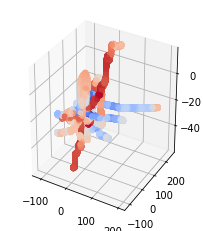

In [6]:
mri_simu = MRI_simulation()
mri_para = MRI_parameters()

#################################################################################
#########################  Pre-defined parameters ###############################
mri_para.stype='PGSE'                                # sequence type
mri_para.bvalue = 1000;                              # bvalue
mri_para.delta, mri_para.Delta = 10600, 43100        # time sequence
mri_para.set_gradient_dir(mymesh, 1, 0, 0)           # gradient direction

mri_para.T = mri_para.Delta+mri_para.delta
mri_para.fs_sym = sp.Piecewise(
                (  1., mri_para.s < mri_para.delta ),
                (  0., mri_para.s < mri_para.Delta ),
                ( -1., mri_para.s < mri_para.T ),
                (  0., True )  
            ) 


mri_para.Apply()
mri_simu.k = 200;                                    # time-step size
mri_simu.nskip = 1;                                  # frequency to print ouputs
mydomain = MyDomain(mymesh, mri_para)
mydomain.phase = None
mydomain.PeriodicDir = [0, 0, 0];             # Direction of the periodicity
mydomain.IsDomainPeriodic = False             # Confirm if the mesh if periodic
mydomain.IsDomainMultiple = False             # Confirm if the mesh is multiple
mydomain.kappa = 1e-5                         # Permeability
################################################################################
mydomain.Apply()   # Call Apply before setting the diffusion tensor
################################################################################
# Impose the diffusion coefficient
mydomain.D0 = 3e-3
mydomain.D = mydomain.D0;
#################################################################################

# linsolver = PETScLUSolver("mumps")
linsolver = KrylovSolver("bicgstab")

mri_simu.solve(mydomain, mri_para, linsolver)

Post_processing(mydomain, mri_para, mri_simu, plt)